# 서두
1. 해당 실험의 설계 
1.1 데이터 준비하기
1.2 데이터 벡터화하기
1.3 모델 준비하기(8개)
1.4 단어장 수 정의하기 
1.5 학습
1.6 예측
1.7 성능 분석
2. 필요한 것
2.1 로이터 뉴스 데이터
2.2 데이터 정제
2.3 각 모델에 대한 지식
2.4 평가 기준

# 데이터 준비하기

In [27]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf

In [4]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)

/home/aiffel-dj15/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/aiffel-dj15/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


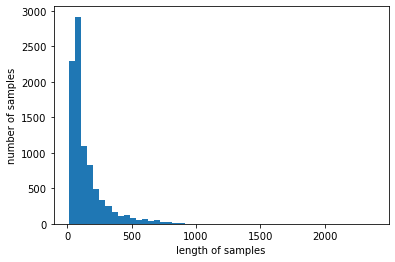

In [3]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

단순 평균값을 보는게 아닌 분포값을 보기 위해서 numpy를 이용하겠다. 

In [5]:
import pandas as pd
x_train_len = [len(x) for x in x_train]
x_train_len = pd.DataFrame(x_train_len)
x_train_len.describe()


,0
count,8982.000000
mean,145.539857
std,145.822248
min,13.000000
25%,60.000000
50%,95.000000
75%,179.000000
max,2376.000000


클래스의 분포도 알아보자

/home/aiffel-dj15/anaconda3/envs/aiffel/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

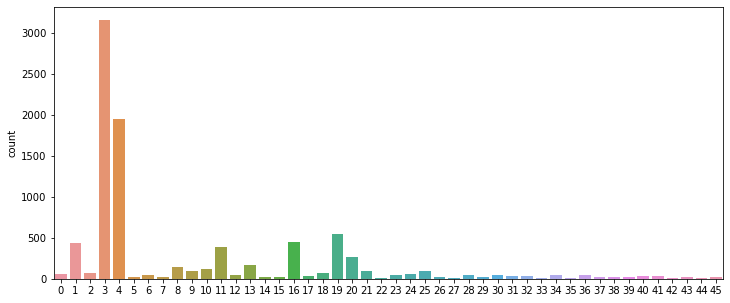

In [6]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12,5)
sns.countplot(y_train)

In [7]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


워드 인덱스를 가져와서 원래 뉴스로 바꿀 수 있는 방법을 보자. 

In [8]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

근데 여기서 미리 인덱스를 앞에 지정해 둔 특수한 역할을 하는 단어들이 있어서 실제 단어를 구하려면 인덱스값에 3을 더해야 구할 수 있다. 
그 정체는 바로 `<pad>, <sos>, <unk>`. 이를 index_to_word에 추가해주자

In [9]:
index_to_word = {index + 3 : word for word, index in word_index.items()}
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token

In [10]:
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


전체 데이터를 다시 원복해본다. 

In [11]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded

In [51]:
x_train

array([list([1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]),
       list([1, 3267, 699, 3434, 2295, 56, 2, 7511, 9, 56, 3906, 1073, 81, 5, 1198, 57, 366, 737, 132, 20, 4093, 7, 2, 49, 2295, 2, 1037, 3267, 699, 3434, 8, 7, 10, 241, 16, 855, 129, 231, 783, 5, 4, 587, 2295, 2, 2, 775, 7, 48, 34, 191, 44, 35, 1795, 505, 17, 12]),
       list([1, 53, 12, 284, 15, 14, 272, 26, 53, 959, 32, 818, 15, 14, 272, 26, 39, 684, 70, 11, 14, 12, 3886, 18, 180, 183, 187, 70, 11, 14, 102, 32, 11, 29, 53, 44, 704, 15, 14, 19, 758, 15, 53, 959, 47, 1013, 15, 14, 19, 132, 15, 39, 965, 32, 11, 14, 147, 72, 11, 180, 183, 187, 44, 11, 14, 102, 19, 11, 123, 186, 90, 67, 960, 4, 78, 13, 68, 467, 511, 110,

# 데이터 벡터화 하기

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


DTM 개념을 가지고 텍스트를 벡터로 바꿔준다. 

In [84]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)
x_test_dtm = dtmvector.transform(x_test)
print(x_test_dtm.shape)
test_tfidfv = tfidf_transformer.transform(x_test_dtm)
print(test_tfidfv.shape)

(8982, 9670)
(8982, 9670)
(2246, 9670)
(2246, 9670)


(2246, 8819)
(2246, 8819)


In [13]:
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산

In [76]:
print(y_train.shape)

(8982,)


In [79]:
mod = MultinomialNB()
mod.fit(tfidfv, y_train)

MultinomialNB()

In [85]:
predicted = mod.predict(test_tfidfv) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6567230632235085


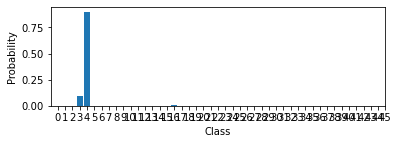

In [22]:
plt.subplot(211)
plt.rcParams["figure.figsize"] = (10,10)
plt.bar(mod.classes_, mod.predict_proba(tfidfv_test[3])[0])
plt.xlim(-1, 21)
plt.xticks(mod.classes_)
plt.xlabel("Class")
plt.ylabel("Probability")
plt.show()

In [23]:
mod.predict(tfidfv_test[3])

array([4])

# 성능 분석 지표

In [14]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [25]:
print(classification_report(y_test, mod.predict(tfidfv_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.62      0.69      0.65       105
           2       0.00      0.00      0.00        20
           3       0.81      0.90      0.85       813
           4       0.51      0.96      0.67       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.08      0.15        25
          10       0.00      0.00      0.00        30
          11       0.66      0.63      0.64        83
          12       0.00      0.00      0.00        13
          13       1.00      0.03      0.05        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.69      0.56      0.61        99
          17       0.00    

/home/aiffel-dj15/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj15/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj15/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

결과 아래의 세 지표는 다음과 같은 의미를 가진다.
- macro: 단순평균
- weighted: 각 클래스에 속하는 표본의 개수로 가중평균
- accuracy: 정확도. 전체 학습 데이터의 개수에서 클래스를 정확하게 맞춘 개수의 비율.

# 여러 모델 정의하기

## Complement Naive Bayes Classifier(CNB)

In [26]:
cb = ComplementNB()
cb.fit(tfidfv, y_train)
predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7707034728406055


## 로지스틱 회귀(Logistic Regression)
소프트맥스 함수(확률값을 구하는 함수)를 통해 다중 클래스의 라벨을 분류

In [27]:
lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)
predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8076580587711487


/home/aiffel-dj15/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## SVD 
**SV는 Decision Boundary와 가까운 class들의 값들을 의미한다.**

In [28]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)


/home/aiffel-dj15/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1000, dual=False, max_iter=500, penalty='l1')

In [29]:
predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.782279608192342


## 트리 기반 & 앙상블

### 결정 트리
`지금까지의 모델 중 가장 낮은 정확도인 62%를 얻습니다. 사실 트리 계열의 모델들은 고차원이고 희소한 데이터에 대해서는 성능이 나오지 않는다는 특징이 있습니다. DTM이나 TF-IDF 행렬의 경우 고차원이면서 대부분의 값이 0인 희소한 데이터이므로 트리 계열의 모델보다는 선형 분류 모델을 통해 접근하는 것이 더 나은 접근일 수 있습니다.`

In [30]:
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)
predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6202137132680321


### 앙상블

#### 렌덤 포레스트
결정 트리의 과적합 문제를 해결. 한꺼번에 여러 트리를 학습시키고 이 중 가장 좋은 값을 꼽는다. 

In [31]:
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)
predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.674087266251113


#### 그래디언트 부스팅 트리(GradientBoostingClassifier)
렌덤 포레스트와 다른 점은, 한 트리를 학습시키고 난 후 그 오차를 다음 트리에 반영해서 오차를 줄여나간다는 것이다.
특징은 다음과 같다.
- 일부 특성 무시
- 깊이가 그렇게 깊지 않음(1-5) => 메모리 적게 사용
- 트리 기반이기 때문에 희소 데이터 학습에서 성능을 내지 못함
- 학습 시 순차적으로 하기 때문에 학습 시간은 오래 걸리나, 빠른 예측 가능

In [32]:
grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)
predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7666963490650045


#### Voting
소프트 보팅과 하드 보팅이 있다. 
하드 보팅은 결과물에 대한 최종 예측값을 투표로 결정한다. 소프트 보팅은 최종 결과물이 나올 `확률값`을 다 더해서 최종 결과물에 대한 각각의 확률을 구한 뒤 최종값을 도출한다. 

In [33]:
voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier.fit(tfidfv, y_train)
predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8116651825467498


# 모델 준비하기

## 단어장 세 개 준비하기

In [42]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)
(x_train_voc_all, y_train_voc_all), (x_test_voc_all, y_test_voc_all) = reuters.load_data(test_split=0.2)

In [20]:
(x_train_voc_half, y_train_voc_half), (x_test_voc_half, y_test_voc_half) = reuters.load_data(num_words=5000, test_split=0.2)

In [43]:
(x_train_voc_double, y_train_voc_double), (x_test_voc_double, y_test_voc_double) = reuters.load_data(num_words=20000, test_split=0.2)

## 모델 준비하기

In [30]:
def vectorize_doc(data, test) :
    dtmvector = CountVectorizer()
    data_dtm = dtmvector.fit_transform(data)
    print(data_dtm.shape)
    tfidf_transformer = TfidfTransformer()
    tfidfv = tfidf_transformer.fit_transform(data_dtm)
    print(tfidfv.shape)
    
    test_dtm = dtmvector.transform(test)
    print(test_dtm.shape)
    test_tfidfv = tfidf_transformer.transform(test_dtm)
    print(test_tfidfv.shape)
    return tfidfv, test_tfidfv

In [44]:
# 함수의 인자는 반드시 벡터화가 되어있는 상태여야 한다. 
def NB_model(train_data, train_label, test_data, test_label) :
    mod = MultinomialNB()
    mod.fit(train_data, train_label)
    predicted = mod.predict(test_data) #테스트 데이터에 대한 예측
    print("Naive Bayes 정확도:", accuracy_score(test_label, predicted)) #예측값과 실제값 비교
    print("confusion matrix")
    cm = confusion_matrix(test_label, predicted)
    print(cm)
    return predicted

In [45]:
def CB_model(train_data, train_label, test_data, test_label) :
    cb = ComplementNB()
    cb.fit(train_data, train_label)
    predicted = cb.predict(test_data) #테스트 데이터에 대한 예측
    print("Complement NB 정확도:", accuracy_score(test_label, predicted)) #예측값과 실제값 비교
    print("confusion matrix")
    cm = confusion_matrix(test_label, predicted)
    print(cm)
    return predicted

In [46]:
def LR_model(train_data, train_label, test_data, test_label) :
    lr = LogisticRegression(C=10000, penalty='l2')
    lr.fit(train_data, train_label)
    predicted = lr.predict(test_data) #테스트 데이터에 대한 예측
    print("Logistic Regression 정확도:", accuracy_score(test_label, predicted)) #예측값과 실제값 비교
    print("confusion matrix")
    cm = confusion_matrix(test_label, predicted)
    return predicted

In [47]:
def SVD_model(train_data, train_label, test_data, test_label) :
    lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
    lsvc.fit(train_data, train_label)
    predicted = lsvc.predict(test_data) #테스트 데이터에 대한 예측
    print("SVD 정확도:", accuracy_score(test_label, predicted)) #예측값과 실제값 비교
    print("confusion matrix")
    cm = confusion_matrix(test_label, predicted)
    return predicted

In [48]:
def DT_model(train_data, train_label, test_data, test_label) :
    tree = DecisionTreeClassifier(max_depth=10, random_state=0)
    tree.fit(train_data, train_label)
    predicted = tree.predict(test_data) #테스트 데이터에 대한 예측
    print("결정 트리 정확도:", accuracy_score(test_label, predicted)) #예측값과 실제값 비교
    print("confusion matrix")
    cm = confusion_matrix(test_label, predicted)
    return predicted

In [49]:
def RF_model(train_data, train_label, test_data, test_label) :
    forest = RandomForestClassifier(n_estimators=5, random_state=0)
    forest.fit(train_data, train_label)
    predicted = forest.predict(test_data) #테스트 데이터에 대한 예측
    print("Random Forest 정확도:", accuracy_score(test_label, predicted)) #예측값과 실제값 비교
    print("confusion matrix")
    cm = confusion_matrix(test_label, predicted)
    return predicted

In [50]:
def GB_model(train_data, train_label, test_data, test_label) :
    grbt = GradientBoostingClassifier(random_state=0) # verbose=3
    grbt.fit(train_data, train_label)
    predicted = grbt.predict(test_data) #테스트 데이터에 대한 예측
    print("GradientBoosting Tree 정확도:", accuracy_score(test_label, predicted)) #예측값과 실제값 비교
    print("confusion matrix")
    cm = confusion_matrix(test_label, predicted)
    return predicted

In [51]:
def Voting_model(train_data, train_label, test_data, test_label) :
    voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
        ], voting='soft', n_jobs=-1)
    voting_classifier.fit(train_data, train_label)
    predicted = voting_classifier.predict(test_data) #테스트 데이터에 대한 예측
    print("Voting 정확도:", accuracy_score(test_label, predicted)) #예측값과 실제값 비교
    print("confusion matrix")
    cm = confusion_matrix(test_label, predicted)
    return predicted

In [52]:
def learning_model(train_data, train_label, test_data, test_label) : 
    predicted_results = []
    rs = NB_model(train_data, train_label, test_data, test_label)
    predicted_results.append(rs)
    rs = CB_model(train_data, train_label, test_data, test_label)
    predicted_results.append(rs)
    rs = LR_model(train_data, train_label, test_data, test_label)
    predicted_results.append(rs)
    rs = SVD_model(train_data, train_label, test_data, test_label)
    predicted_results.append(rs)
    rs = DT_model(train_data, train_label, test_data, test_label)
    predicted_results.append(rs)
    rs = RF_model(train_data, train_label, test_data, test_label)
    predicted_results.append(rs)
    rs = GB_model(train_data, train_label, test_data, test_label)
    predicted_results.append(rs)
    rs = Voting_model(train_data, train_label, test_data, test_label)
    predicted_results.append(rs)
    return predicted_results

In [53]:
(x_train_voc_all, y_train_voc_all), (x_test_voc_all, y_test_voc_all) 
(x_train_voc_half, y_train_voc_half), (x_test_voc_half, y_test_voc_half)
(x_train_voc_double, y_train_voc_double), (x_test_voc_double, y_test_voc_double)

((array([list([1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]),
         list([1, 3267, 699, 3434, 2295, 56, 16784, 7511, 9, 56, 3906, 1073, 81, 5, 1198, 57, 366, 737, 132, 20, 4093, 7, 19261, 49, 2295, 13415, 1037, 3267, 699, 3434, 8, 7, 10, 241, 16, 855, 129, 231, 783, 5, 4, 587, 2295, 13415, 2, 775, 7, 48, 34, 191, 44, 35, 1795, 505, 17, 12]),
         list([1, 53, 12, 284, 15, 14, 272, 26, 53, 959, 32, 818, 15, 14, 272, 26, 39, 684, 70, 11, 14, 12, 3886, 18, 180, 183, 187, 70, 11, 14, 102, 32, 11, 29, 53, 44, 704, 15, 14, 19, 758, 15, 53, 959, 47, 1013, 15, 14, 19, 132, 15, 39, 965, 32, 11, 14, 147, 72, 11, 180, 183, 187, 44, 11, 14, 102, 19, 11, 123, 186, 90, 67, 960, 4, 78, 

In [54]:
train_data_list = [x_train_voc_half, x_train_voc_double, x_train_voc_all]
train_label_list = [y_train_voc_half, y_train_voc_double, y_train_voc_all]  
test_data_list = [x_test_voc_half, x_test_voc_double, x_test_voc_all]
test_label_list = [y_test_voc_half, y_test_voc_double, y_test_voc_all]  

In [55]:
train_data_list[1]

array([list([1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]),
       list([1, 3267, 699, 3434, 2295, 56, 16784, 7511, 9, 56, 3906, 1073, 81, 5, 1198, 57, 366, 737, 132, 20, 4093, 7, 19261, 49, 2295, 13415, 1037, 3267, 699, 3434, 8, 7, 10, 241, 16, 855, 129, 231, 783, 5, 4, 587, 2295, 13415, 2, 775, 7, 48, 34, 191, 44, 35, 1795, 505, 17, 12]),
       list([1, 53, 12, 284, 15, 14, 272, 26, 53, 959, 32, 818, 15, 14, 272, 26, 39, 684, 70, 11, 14, 12, 3886, 18, 180, 183, 187, 70, 11, 14, 102, 32, 11, 29, 53, 44, 704, 15, 14, 19, 758, 15, 53, 959, 47, 1013, 15, 14, 19, 132, 15, 39, 965, 32, 11, 14, 147, 72, 11, 180, 183, 187, 44, 11, 14, 102, 19, 11, 123, 186, 90, 67, 960, 4, 78, 13, 68

text 데이터를 넣어줘야 한다. 

In [56]:
def decoded(data) :
    decoded = []
    for i in range(len(data)):
        t = ' '.join([index_to_word[index] for index in data[i]])
        decoded.append(t)
    return decoded

In [57]:
train_data_list_t = []
test_data_list_t = []
for i in range(3) :
    train_data_list_t.append(decoded(train_data_list[i]))
    test_data_list_t.append(decoded(test_data_list[i]))


In [58]:
train_data_list_v = []
test_data_list_v = []
for i in range(3) :
    train, test = vectorize_doc(train_data_list_t[i], test_data_list_t[i])
    train_data_list_v.append(train)
    test_data_list_v.append(test)    

(8982, 4867)
(8982, 4867)
(2246, 4867)
(2246, 4867)
(8982, 18479)
(8982, 18479)
(2246, 18479)
(2246, 18479)
(8982, 26506)
(8982, 26506)
(2246, 26506)
(2246, 26506)


In [59]:
predicted_result = []
print_label = ['half', 'double','all']
for i in range(3) :
    print(print_label[i])
    predicted_result.append(learning_model(train_data_list_v[i], train_label_list[i], test_data_list_v[i], test_label_list[i]))

half
Naive Bayes 정확도: 0.6731967943009796
confusion matrix
[[ 0  4  0 ...  0  0  0]
 [ 0 84  0 ...  0  0  0]
 [ 0  7  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
Complement NB 정확도: 0.7707034728406055
confusion matrix
[[ 7  2  0 ...  0  0  0]
 [ 0 90  0 ...  0  0  0]
 [ 0  5 10 ...  0  0  0]
 ...
 [ 0  0  0 ...  1  0  0]
 [ 0  1  0 ...  0  4  0]
 [ 0  0  0 ...  0  0  1]]


/home/aiffel-dj15/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression 정확도: 0.8058771148708815
confusion matrix


/home/aiffel-dj15/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVD 정확도: 0.7791629563668745
confusion matrix
결정 트리 정확도: 0.6179875333926982
confusion matrix
Random Forest 정확도: 0.701246660730187
confusion matrix
GradientBoosting Tree 정확도: 0.767586821015138
confusion matrix
Voting 정확도: 0.8161175422974176
confusion matrix
double
Naive Bayes 정확도: 0.6193232413178985
confusion matrix
[[ 0  0  0 ...  0  0  0]
 [ 0 41  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
Complement NB 정확도: 0.7671415850400712
confusion matrix
[[ 6  3  0 ...  0  0  0]
 [ 0 93  0 ...  0  0  0]
 [ 0  4 10 ...  0  0  0]
 ...
 [ 0  0  0 ...  1  0  0]
 [ 0  1  0 ...  0  4  0]
 [ 0  0  0 ...  0  0  1]]


/home/aiffel-dj15/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression 정확도: 0.8098842386464826
confusion matrix


/home/aiffel-dj15/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVD 정확도: 0.7796081923419412
confusion matrix
결정 트리 정확도: 0.6211041852181657
confusion matrix
Random Forest 정확도: 0.6714158504007124
confusion matrix
GradientBoosting Tree 정확도: 0.769813000890472
confusion matrix
Voting 정확도: 0.8178984861976848
confusion matrix
all
Naive Bayes 정확도: 0.5997328584149599
confusion matrix
[[ 0  0  0 ...  0  0  0]
 [ 0 22  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
Complement NB 정확도: 0.7649154051647373
confusion matrix
[[ 6  3  0 ...  0  0  0]
 [ 0 92  0 ...  0  0  0]
 [ 0  4 10 ...  0  0  0]
 ...
 [ 0  0  0 ...  1  0  0]
 [ 0  1  0 ...  0  4  0]
 [ 0  0  0 ...  0  0  1]]


/home/aiffel-dj15/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression 정확도: 0.813446126447017
confusion matrix


/home/aiffel-dj15/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVD 정확도: 0.7818343722172751
confusion matrix
결정 트리 정확도: 0.6211041852181657
confusion matrix
Random Forest 정확도: 0.6544968833481746
confusion matrix
GradientBoosting Tree 정확도: 0.7702582368655387
confusion matrix
Voting 정확도: 0.8187889581478184
confusion matrix


In [61]:
predicted_result_tm = []
for i in range(3) : 
    predicted_result_tm.append(predicted_result[i][0])

In [64]:
predicted_result

[[array([3, 1, 1, ..., 3, 4, 1]),
  array([ 3, 10,  1, ...,  3,  4,  1]),
  array([ 3, 10,  1, ...,  3,  4, 24]),
  array([ 3, 10,  1, ...,  3,  4, 24]),
  array([ 3, 10,  4, ...,  3,  4,  4]),
  array([ 3, 10,  1, ...,  3,  4,  1]),
  array([ 3, 10,  1, ...,  3,  4, 24]),
  array([ 3, 10,  1, ...,  3,  4, 24])],
 [array([3, 4, 4, ..., 3, 4, 4]),
  array([ 3, 10,  1, ...,  3,  4,  1]),
  array([ 3, 10,  1, ...,  3,  4, 24]),
  array([ 3, 10,  1, ...,  3,  4, 24]),
  array([ 4, 10,  4, ...,  3,  4,  4]),
  array([ 3, 16,  1, ...,  3,  4,  1]),
  array([ 3, 10,  1, ...,  3, 15, 24]),
  array([ 3, 10,  1, ...,  3,  4, 24])],
 [array([3, 4, 4, ..., 3, 4, 4]),
  array([ 3, 10,  1, ...,  3,  4,  1]),
  array([ 3, 10,  1, ...,  3,  4, 24]),
  array([ 3, 10,  1, ...,  3,  4, 24]),
  array([27, 10,  4, ...,  3,  4,  4]),
  array([3, 6, 1, ..., 3, 3, 4]),
  array([ 3, 10,  1, ...,  3,  3, 24]),
  array([ 3, 10,  1, ...,  3,  4, 24])]]

# 모델 평가하기

In [65]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from keras import backend as K
from sklearn.metrics import f1_score
label = ["Naive Bayes","Complement NB","Logistic Regression","SVD","결정 트리","Random Forest","GradientBoosting Tree","Voting"]
for i in range(3) :
    print(f"task {i}")
    for j in range(8) :
        print(label[j])
        print(f1_score(test_label_list[i],predicted_result[i][j],average='weighted'))        

task 0
Naive Bayes
0.6012501291711391
Complement NB
0.7458990404916549
Logistic Regression
0.7994583667437475
SVD
0.7745004723426424
결정 트리
0.5729970881280324
Random Forest
0.6770217603524399
GradientBoosting Tree
0.7662475269931749
Voting
0.8126712904613167
task 1
Naive Bayes
0.5315181088041159
Complement NB
0.7390612170450325
Logistic Regression
0.8037422072911045
SVD
0.7749168932807547
결정 트리
0.576123209915252
Random Forest
0.6408515630206083
GradientBoosting Tree
0.7643068930655441
Voting
0.8141015194908785
task 2
Naive Bayes
0.5045670886188423
Complement NB
0.7346534179503126
Logistic Regression
0.8079349566211766
SVD
0.7764096115507159
결정 트리
0.5769283128518846
Random Forest
0.6225909375608356
GradientBoosting Tree
0.7641672650539437
Voting
0.8147231278247327


결과에 대해서 task0은 단어 수가 5000개, task1은 단어 수가 20000개, task2는 전체 단어를 사용했다. 셋을 비교했을 때, Voting이 f1-score가 가장 높게 나왔다. 그리고 Logistic Regression은 Voting에 비해 학습 시간이 짧음에도 불구하고 거의 비슷한 성능을 냈다. 세 task중 단어 수를 전부 다 쓴 세 번째 경우가 score가 가장 높았다. 

[1,
 2,
 2,
 8,
 43,
 10,
 447,
 5,
 25,
 207,
 270,
 5,
 3095,
 111,
 16,
 369,
 186,
 90,
 67,
 7,
 89,
 5,
 19,
 102,
 6,
 19,
 124,
 15,
 90,
 67,
 84,
 22,
 482,
 26,
 7,
 48,
 4,
 49,
 8,
 864,
 39,
 209,
 154,
 6,
 151,
 6,
 83,
 11,
 15,
 22,
 155,
 11,
 15,
 7,
 48,
 9,
 4579,
 1005,
 504,
 6,
 258,
 6,
 272,
 11,
 15,
 22,
 134,
 44,
 11,
 15,
 16,
 8,
 197,
 1245,
 90,
 67,
 52,
 29,
 209,
 30,
 32,
 132,
 6,
 109,
 15,
 17,
 12]

In [25]:
x_train_voc_half_d = decoded(x_train_voc_half)
x_test_voc_half_d = decoded(x_test_voc_half)

In [33]:
x_train_voc_half_v, x_test_voc_half_v = vectorize_doc(x_train_voc_half_d, x_test_voc_half_d)

(8982, 4867)
(8982, 4867)
(2246, 4867)
(2246, 4867)


In [72]:
train_label_onehot = tf.keras.utils.to_categorical(train_label_list[0],46)
#train_label_onehot = tf.keras.utils.to_categorical(y_train_voc_half,46)
train_label_onehot[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [73]:
import tensorflow as tf
batch_size = 50

tf_pipeline = tf.data.Dataset.from_tensor_slices((train_data_list_v[0].toarray(), train_label_onehot)).batch(batch_size)
#tf_pipeline = tf.data.Dataset.from_tensor_slices((x_train_voc_half_v.toarray(), train_label_onehot)).batch(batch_size)

In [68]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [74]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

model = Sequential()

model.add(Dense(512, input_shape=(4867,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(46))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',f1_m])
model.summary()
print(model.metrics_names)

ResourceExhaustedError: OOM when allocating tensor with shape[4867,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

In [70]:
tf_pipeline

<BatchDataset shapes: ((None, 26506), (None, 46)), types: (tf.float64, tf.float32)>

In [38]:
history = model.fit(tf_pipeline, epochs=10, verbose=2)

Epoch 1/10
180/180 - 1s - loss: 1.8088 - accuracy: 0.6220 - f1_m: 0.4959
Epoch 2/10
180/180 - 0s - loss: 0.9113 - accuracy: 0.7974 - f1_m: 0.7791
Epoch 3/10
180/180 - 0s - loss: 0.6329 - accuracy: 0.8565 - f1_m: 0.8387
Epoch 4/10
180/180 - 0s - loss: 0.4576 - accuracy: 0.8947 - f1_m: 0.8809
Epoch 5/10
180/180 - 0s - loss: 0.3466 - accuracy: 0.9164 - f1_m: 0.9065
Epoch 6/10
180/180 - 0s - loss: 0.2720 - accuracy: 0.9336 - f1_m: 0.9240
Epoch 7/10
180/180 - 0s - loss: 0.2164 - accuracy: 0.9418 - f1_m: 0.9371
Epoch 8/10
180/180 - 0s - loss: 0.1826 - accuracy: 0.9467 - f1_m: 0.9445
Epoch 9/10
180/180 - 0s - loss: 0.1561 - accuracy: 0.9503 - f1_m: 0.9493
Epoch 10/10
180/180 - 0s - loss: 0.1403 - accuracy: 0.9530 - f1_m: 0.9525


In [39]:
#test_label_onehot = tf.keras.utils.to_categorical(test_label_list[0],46)
test_label_onehot = tf.keras.utils.to_categorical(y_test_voc_half,46)
test_label_onehot[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

머신러닝은 FC와 Dropout을 섞어서 만들었고, GPU 자원을 고려해서 단어장이 5000개인 경우를 사용했다. 

In [41]:
history = model.evaluate(x_test_voc_half_v.toarray(),test_label_onehot)

71/71 [==============================] - 0s 1ms/step - loss: 0.7985 - accuracy: 0.8112 - f1_m: 0.8123


# 평가
루브릭 3번이 이해가 되지 않는다. BLEU는 바탕이 되는 문장에서 학습을 통해 생성된 문장이 의도한 바에 부합하는지 평가하는 지표이기 때문이다.(ref : https://machinelearningmastery.com/calculate-bleu-score-for-text-python/ ) 이 루브릭을 쓴 자는 분명히 루브릭 작성 도중에 졸았을 것이다. 그래서 ML에서 썼던 스코어를 그대로 사용해서 평가한다. F1-score를 봤을 때, 머신러닝이 시간이 빠르면서도 Voting 만큼의 성능을 내는 것을 볼 수 있다. 


# Reference
1. 로이터 뉴스에 Dense layer 적용해서 학습시키기 
https://towardsdatascience.com/text-classification-in-keras-part-1-a-simple-reuters-news-classifier-9558d34d01d3
2. 학습 평가 지표 계산 함수 
https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model